In [2]:
import osmium as osm
import pandas as pd
import geopandas
import os.path
import os
import shapely.wkb as wkblib
wkbfab = osm.geom.WKBFactory()
import numpy as np
import shapely.geometry

from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
import jenkspy
from sklearn.metrics import PrecisionRecallDisplay

In [3]:
class AreaHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.num_polys = 0
        self.osm_data = []
        self.roads_data = []
        self.landuse_data = []
        self.amenity_data = []
        
    def count_polygons(self):
        self.num_polys += 1
        
    def way(self, w):
        try:
            wkb = wkbfab.create_linestring(w)
            line = wkblib.loads(wkb, hex=True)
            for tag in w.tags:
                if (tag.k=='highway'):
                    self.roads_data.append([w.id,
                                       tag.v,
                                       line])
        except Exception:
            pass    
        
    def area(self, a):
        try:
            wkb = wkbfab.create_multipolygon(a)
            self.count_polygons()
            # load into shapely
            poly = wkblib.loads(wkb, hex=True)
            for tag in a.tags:
                if (tag.k=='building'):
                    self.osm_data.append([a.id,                                   
                                    tag.v,
                                    list(poly.geoms)[0],
                                    list(dict(a.tags).keys()),
                                    dict(a.tags)])
                if (tag.k=='landuse'):
                    self.landuse_data.append([tag.v,
                                    list(poly.geoms)[0],
                                    ])
                if (tag.k == 'amenity'):
                    self.amenity_data.append([tag.v,
                                    list(poly.geoms)[0],
                                    ])
        except Exception:
            pass

In [4]:
# load official buildings
buildings_path = "/DATA2/dse313/group15//Datasets/Official/Boulder_admin_buildings/Boulder_admin_buildings.shp"
official_buildings = geopandas.read_file(buildings_path)

In [5]:
official_buildings.shape

(46760, 3)

In [6]:
official_buildings.columns

Index(['OBJECTID', 'BLDGTYPE', 'geometry'], dtype='object')

In [7]:
official_buildings = official_buildings.rename(columns={'BLDGTYPE': 'official_type',})

In [8]:
official_buildings.head()

,OBJECTID,official_type,geometry
0,1,Garage/Shed,"POLYGON ((-105.26283 40.03670, -105.26281 40.0..."
1,2,Garage/Shed,"POLYGON ((-105.27005 40.05542, -105.27002 40.0..."
2,3,Garage/Shed,"POLYGON ((-105.26851 40.05556, -105.26851 40.0..."
3,4,Garage/Shed,"POLYGON ((-105.26754 40.05450, -105.26754 40.0..."
4,5,Garage/Shed,"POLYGON ((-105.26748 40.05450, -105.26748 40.0..."


In [9]:
official_buildings.groupby(['official_type']).count()

,OBJECTID,geometry
official_type,,
Agricultural,73,73
Commercial,2486,2486
Foundation/Ruin,32,32
Garage/Shed,14345,14345
Industrial,308,308
Medical,64,64
Misc,508,508
Parking Structure,20,20
Public,318,318


In [10]:
#dissolved_buildings = official_buildings.dissolve()

In [11]:
#dissolved_buildings.bounds

In [12]:
official_buildings.head()

,OBJECTID,official_type,geometry
0,1,Garage/Shed,"POLYGON ((-105.26283 40.03670, -105.26281 40.0..."
1,2,Garage/Shed,"POLYGON ((-105.27005 40.05542, -105.27002 40.0..."
2,3,Garage/Shed,"POLYGON ((-105.26851 40.05556, -105.26851 40.0..."
3,4,Garage/Shed,"POLYGON ((-105.26754 40.05450, -105.26754 40.0..."
4,5,Garage/Shed,"POLYGON ((-105.26748 40.05450, -105.26748 40.0..."


In [13]:
official_buildings.groupby('official_type').count()

,OBJECTID,geometry
official_type,,
Agricultural,73,73
Commercial,2486,2486
Foundation/Ruin,32,32
Garage/Shed,14345,14345
Industrial,308,308
Medical,64,64
Misc,508,508
Parking Structure,20,20
Public,318,318


In [14]:
drop_list = ['Agricultural','Foundation/Ruin','Garage/Shed','Misc','Parking Structure','Tank']
official_buildings.drop(official_buildings[(official_buildings['official_type'].isin(drop_list))].index,\
                        inplace = True)
official_buildings.reset_index(inplace=True, drop=True)

In [15]:
official_buildings.head()

,OBJECTID,official_type,geometry
0,1087,Residential,"POLYGON ((-105.22452 40.03384, -105.22451 40.0..."
1,1088,Residential,"POLYGON ((-105.22304 40.03210, -105.22302 40.0..."
2,1089,Residential,"POLYGON ((-105.22278 40.03214, -105.22275 40.0..."
3,1090,Residential,"POLYGON ((-105.22226 40.03301, -105.22231 40.0..."
4,1091,Residential,"POLYGON ((-105.22309 40.03433, -105.22324 40.0..."


In [16]:
official_buildings.shape

(31641, 3)

In [17]:
official_buildings.groupby('official_type').count()

,OBJECTID,geometry
official_type,,
Commercial,2486,2486
Industrial,308,308
Medical,64,64
Public,318,318
Public Safety,12,12
Religious,55,55
Residential,27992,27992
School,406,406


In [18]:
official_buildings['official_type'] = official_buildings['official_type'].apply(\
                                lambda x: 'RES' if (x == 'Residential'
                                                ) else 'NON_RES')

In [19]:
official_buildings.groupby('official_type').count()

,OBJECTID,geometry
official_type,,
NON_RES,3649,3649
RES,27992,27992


In [20]:
areahandler = AreaHandler()
areahandler.apply_file("/DATA2/dse313/group15/Datasets/OSM/Boulder_City_Buildings.osm.pbf", locations=True)
print("Number of polygons: %d" % areahandler.num_polys)

Number of polygons: 51535


In [21]:
len(areahandler.osm_data)

46142

In [22]:
# transform the list into a pandas DataFrame
data_colnames = ['id', 'building', 'geometry', 'all_tag_keys', 'all_tags']
df = pd.DataFrame(areahandler.osm_data, columns=data_colnames)

In [23]:
df.head()

,id,building,geometry,all_tag_keys,all_tags
0,52441514,yes,"POLYGON ((-105.1344036 39.9317353, -105.134093...",[building],{'building': 'yes'}
1,52441612,yes,"POLYGON ((-105.134853 39.9306038, -105.1347313...","[building, name, shop]","{'building': 'yes', 'name': '2nd and Charles',..."
2,52441656,yes,"POLYGON ((-105.135584 39.9306925, -105.1355762...","[addr:housenumber, addr:street, building]","{'addr:housenumber': '61', 'addr:street': 'Wes..."
3,52441786,yes,"POLYGON ((-105.1360267 39.9299163, -105.135822...","[addr:city, addr:postcode, addr:street, amenit...","{'addr:city': 'Broomfield', 'addr:postcode': '..."
4,57550862,dormitory,"POLYGON ((-105.2661969 40.0058641, -105.266196...","[addr:city, addr:housenumber, addr:street, bui...","{'addr:city': 'Boulder', 'addr:housenumber': '..."


In [24]:
gdf = geopandas.GeoDataFrame(df, crs=4326, geometry='geometry')

<AxesSubplot:>

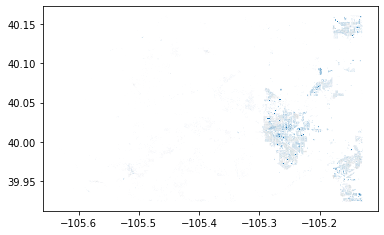

In [25]:
gdf.plot()

In [26]:
gdf.head()

,id,building,geometry,all_tag_keys,all_tags
0,52441514,yes,"POLYGON ((-105.13440 39.93174, -105.13409 39.9...",[building],{'building': 'yes'}
1,52441612,yes,"POLYGON ((-105.13485 39.93060, -105.13473 39.9...","[building, name, shop]","{'building': 'yes', 'name': '2nd and Charles',..."
2,52441656,yes,"POLYGON ((-105.13558 39.93069, -105.13558 39.9...","[addr:housenumber, addr:street, building]","{'addr:housenumber': '61', 'addr:street': 'Wes..."
3,52441786,yes,"POLYGON ((-105.13603 39.92992, -105.13582 39.9...","[addr:city, addr:postcode, addr:street, amenit...","{'addr:city': 'Broomfield', 'addr:postcode': '..."
4,57550862,dormitory,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...","[addr:city, addr:housenumber, addr:street, bui...","{'addr:city': 'Boulder', 'addr:housenumber': '..."


In [27]:
gdf.groupby('building').count().sort_values(by=['building'], inplace=False, ascending=True).tail(50)

,id,geometry,all_tag_keys,all_tags
building,,,,
amenity,4,4,4,4
apartments,1558,1558,1558,1558
barn,23,23,23,23
cabin,11,11,11,11
carport,9,9,9,9
church,48,48,48,48
civic,3,3,3,3
college,1,1,1,1
commercial,275,275,275,275


In [28]:
# transform the list into a pandas DataFrame
land_colnames = ['landuse', 'geometry']
land_df = pd.DataFrame(areahandler.landuse_data, columns=land_colnames)

In [29]:
land_df.shape

(1161, 2)

In [30]:
land_df.head()

,landuse,geometry
0,cemetery,"POLYGON ((-105.2703153 39.9952778, -105.270283..."
1,grass,"POLYGON ((-105.2596039 39.9870779, -105.259361..."
2,grass,"POLYGON ((-105.2535182 39.9949753, -105.253162..."
3,recreation_ground,"POLYGON ((-105.1845997 39.968052, -105.1845911..."
4,recreation_ground,"POLYGON ((-105.1595664 39.9451151, -105.159198..."


In [31]:
land_df.groupby('landuse').count()

,geometry
landuse,
allotments,12
cemetery,8
commercial,24
construction,23
farmland,29
farmyard,195
flowerbed,1
forest,7
garages,1


In [32]:
non_res = ['commercial', 'retail','industrial','grass','plant_nursery','quarry','railway','government',\
            'institutional']
land_df['landuse'] = land_df['landuse'].apply(\
                                lambda x: 'non_res' if x in non_res else x)

In [33]:
land_df.groupby('landuse').count()

,geometry
landuse,
allotments,12
cemetery,8
construction,23
farmland,29
farmyard,195
flowerbed,1
forest,7
garages,1
landfill,2


In [34]:
land_gdf = geopandas.GeoDataFrame(land_df, crs=4326, geometry='geometry')

In [35]:
gdf.shape

(46142, 5)

In [36]:
land_gdf.shape

(1161, 2)

In [37]:
buildings_land = gdf.sjoin(land_gdf, how="left", predicate='intersects')

In [38]:
buildings_land.shape

(46269, 7)

In [39]:
buildings_land.drop_duplicates(subset='id',inplace=True)

In [40]:
buildings_land.shape

(46142, 7)

In [41]:
buildings_land.head()

,id,building,geometry,all_tag_keys,all_tags,index_right,landuse
0,52441514,yes,"POLYGON ((-105.13440 39.93174, -105.13409 39.9...",[building],{'building': 'yes'},NaN,NaN
1,52441612,yes,"POLYGON ((-105.13485 39.93060, -105.13473 39.9...","[building, name, shop]","{'building': 'yes', 'name': '2nd and Charles',...",NaN,NaN
2,52441656,yes,"POLYGON ((-105.13558 39.93069, -105.13558 39.9...","[addr:housenumber, addr:street, building]","{'addr:housenumber': '61', 'addr:street': 'Wes...",NaN,NaN
3,52441786,yes,"POLYGON ((-105.13603 39.92992, -105.13582 39.9...","[addr:city, addr:postcode, addr:street, amenit...","{'addr:city': 'Broomfield', 'addr:postcode': '...",NaN,NaN
4,57550862,dormitory,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...","[addr:city, addr:housenumber, addr:street, bui...","{'addr:city': 'Boulder', 'addr:housenumber': '...",857.0,non_res


In [42]:
buildings_land.rename(columns={'index_right': 'index_landuse'},inplace=True)
buildings_land['landuse'] = \
            buildings_land['landuse'].apply(lambda x: 'no_landuse' if pd.isnull(x) else x)
buildings_land.reset_index(inplace=True, drop=True)

In [43]:
buildings_land[buildings_land['landuse'] == 'no_landuse'].shape

(35026, 7)

In [44]:
len(buildings_land.index_landuse.unique())

240

In [45]:
buildings_land.head()

,id,building,geometry,all_tag_keys,all_tags,index_landuse,landuse
0,52441514,yes,"POLYGON ((-105.13440 39.93174, -105.13409 39.9...",[building],{'building': 'yes'},NaN,no_landuse
1,52441612,yes,"POLYGON ((-105.13485 39.93060, -105.13473 39.9...","[building, name, shop]","{'building': 'yes', 'name': '2nd and Charles',...",NaN,no_landuse
2,52441656,yes,"POLYGON ((-105.13558 39.93069, -105.13558 39.9...","[addr:housenumber, addr:street, building]","{'addr:housenumber': '61', 'addr:street': 'Wes...",NaN,no_landuse
3,52441786,yes,"POLYGON ((-105.13603 39.92992, -105.13582 39.9...","[addr:city, addr:postcode, addr:street, amenit...","{'addr:city': 'Broomfield', 'addr:postcode': '...",NaN,no_landuse
4,57550862,dormitory,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...","[addr:city, addr:housenumber, addr:street, bui...","{'addr:city': 'Boulder', 'addr:housenumber': '...",857.0,non_res


In [46]:
buildings_land.groupby('landuse').count()

,id,building,geometry,all_tag_keys,all_tags,index_landuse
landuse,,,,,,
allotments,1,1,1,1,1,1
cemetery,5,5,5,5,5,5
construction,13,13,13,13,13,13
farmyard,26,26,26,26,26,26
forest,2,2,2,2,2,2
garages,1,1,1,1,1,1
meadow,2,2,2,2,2,2
no_landuse,35026,35026,35026,35026,35026,0
non_res,883,883,883,883,883,883


In [47]:
buildings_land.groupby(['landuse','building']).count().head(50)

id  geometry  all_tag_keys  all_tags  \
landuse      building                                                      
allotments   shed                    1         1             1         1   
cemetery     yes                     5         5             5         5   
construction construction            1         1             1         1   
             office                  1         1             1         1   
             residential             1         1             1         1   
             roof                    1         1             1         1   
             warehouse               1         1             1         1   
             yes                     8         8             8         8   
farmyard     house                   3         3             3         3   
             yes                    23        23            23        23   
forest       yes                     2         2             2         2   
garages      garage                  1         1             1         1   
meadow       roof                    1         1             1         1   
             shed                    1         1             1         1   
no_landuse   amenity                 4         4             4         4   
             apartments           1097      1097          1097      1097   
             barn                   23        23            23        23   
             cabin                  11        11            11        11   
             carport                 3         3             3         3   
             church                 43        43            43        43   
             college                 1         1             1         1   
             commercial            192       192           192       192   
             construction            2         2             2         2   
             cowshed                 1         1             1         1   
             detached               57        57            57        57   
             dormitory              11        11            11        11   
             farm_auxiliary          5         5             5         5   
             garage               1255      1255          1255      1255   
             garages               457       457           457       457   
             government              2         2             2         2   
             greenhouse             18        18            18        18   
             hospital                4         4             4         4   
             hotel                  41        41            41        41   
             house               16987     16987         16987     16987   
             industrial             31        31            31        31   
             kindergarten            1         1             1         1   
             museum                  1         1             1         1   
             office                191       191           191       191   
             parking                 3         3             3         3   
             public                 23        23            23        23   
             residential           513       513           513       513   
             retail                217       217           217       217   
             roof                  116       116           116       116   
             ruins                   4         4             4         4   
             school                 66        66            66        66   
             semidetached_house     11        11            11        11   
             shed                  469       469           469       469   
             sports_centre           1         1             1         1   
             stable                  3         3             3         3   
             stadium                21        21            21        21   

                                 index_landuse  
landuse      building             

In [48]:
buildings_land['land_building'] = buildings_land.apply(lambda x: \
    x['landuse'] if x['building'] == 'yes' else x['building'], axis=1)

In [49]:
buildings_land.groupby(['landuse','land_building']).count().head(50)

id  building  geometry  all_tag_keys  \
landuse      land_building                                                 
allotments   shed                    1         1         1             1   
cemetery     cemetery                5         5         5             5   
construction construction            9         9         9             9   
             office                  1         1         1             1   
             residential             1         1         1             1   
             roof                    1         1         1             1   
             warehouse               1         1         1             1   
farmyard     farmyard               23        23        23            23   
             house                   3         3         3             3   
forest       forest                  2         2         2             2   
garages      garage                  1         1         1             1   
meadow       roof                    1         1         1             1   
             shed                    1         1         1             1   
no_landuse   amenity                 4         4         4             4   
             apartments           1097      1097      1097          1097   
             barn                   23        23        23            23   
             cabin                  11        11        11            11   
             carport                 3         3         3             3   
             church                 43        43        43            43   
             college                 1         1         1             1   
             commercial            192       192       192           192   
             construction            2         2         2             2   
             cowshed                 1         1         1             1   
             detached               57        57        57            57   
             dormitory              11        11        11            11   
             farm_auxiliary          5         5         5             5   
             garage               1255      1255      1255          1255   
             garages               457       457       457           457   
             government              2         2         2             2   
             greenhouse             18        18        18            18   
             hospital                4         4         4             4   
             hotel                  41        41        41            41   
             house               16987     16987     16987         16987   
             industrial             31        31        31            31   
             kindergarten            1         1         1             1   
             museum                  1         1         1             1   
             no_landuse          12600     12600     12600         12600   
             office                191       191       191           191   
             parking                 3         3         3             3   
             public                 23        23        23            23   
             residential           513       513       513           513   
             retail                217       217       217           217   
             roof                  116       116       116           116   
             ruins                   4         4         4             4   
             school                 66        66        66            66   
             semidetached_house     11        11        11            11   
             shed                  469       469       469           469   
             sports_centre           1         1         1             1   
             stable                  3         3         3             3   
             stadium                21        21        21            21   

                                 all_tags  index_landuse  
landuse      land_buildi

In [50]:
buildings_land.groupby(['landuse','land_building']).count().tail(50)

id  building  geometry  all_tag_keys  \
landuse           land_building                                               
non_res           commercial           74        74        74            74   
                  construction          2         2         2             2   
                  dormitory            11        11        11            11   
                  garage                1         1         1             1   
                  garages               3         3         3             3   
                  hospital              1         1         1             1   
                  hotel                 3         3         3             3   
                  house                 2         2         2             2   
                  industrial           42        42        42            42   
                  kiosk                 1         1         1             1   
                  non_res             379       379       379           379   
                  office               78        78        78            78   
                  parking               1         1         1             1   
                  public                2         2         2             2   
                  retail              171       171       171           171   
                  roof                 27        27        27            27   
                  service               1         1         1             1   
                  shed                  1         1         1             1   
                  stadium               1         1         1             1   
                  university            2         2         2             2   
                  warehouse            73        73        73            73   
recreation_ground house                 2         2         2             2   
                  recreation_ground    17        17        17            17   
                  retail                1         1         1             1   
                  roof                  2         2         2             2   
                  shed                  4         4         4             4   
residential       apartments          457       457       457           457   
                  carport               6         6         6             6   
                  church                5         5         5             5   
                  commercial            6         6         6             6   
                  construction          3         3         3             3   
                  detached             18        18        18            18   
                  garage              260       260       260           260   
                  garages              17        17        17            17   
                  hotel                28        28        28            28   
                  house              5967      5967      5967          5967   
                  industrial            1         1         1             1   
                  office                6         6         6             6   
                  parking               2         2         2             2   
                  residential        2884      2884      2884          2884   
                  retail                3         3         3             3   
                  roof                  7         7         7             7   
                  school                2         2         2             2   
                  shed                225       225       225           225   
                  static_caravan      214       214       214           214   
                  terrace              19        19        19            19   
storage           office                1         1         1             1   
                  warehouse             4         4         4             4   
winter_sports     commercial            3         3         3             3   
          

In [51]:
def enrich_buildings(buildings_land,tags_list):
    for tag_val in tags_list:
        buildings_land['land_building'] = buildings_land.apply(lambda x: \
            tag_val if x['landuse'] == tag_val else x['land_building'], axis=1)

    return buildings_land

In [52]:
tags_list = ['residential','commercial','religious','recreation_ground','cemetery',\
            'construction','farmland','farmyard','forest','military']
buildings_land = enrich_buildings(buildings_land,tags_list)

In [53]:
buildings_land.groupby(['landuse','land_building']).count().head(50)

id  building  geometry  all_tag_keys  \
landuse      land_building                                                 
allotments   shed                    1         1         1             1   
cemetery     cemetery                5         5         5             5   
construction construction           13        13        13            13   
farmyard     farmyard               26        26        26            26   
forest       forest                  2         2         2             2   
garages      garage                  1         1         1             1   
meadow       roof                    1         1         1             1   
             shed                    1         1         1             1   
no_landuse   amenity                 4         4         4             4   
             apartments           1097      1097      1097          1097   
             barn                   23        23        23            23   
             cabin                  11        11        11            11   
             carport                 3         3         3             3   
             church                 43        43        43            43   
             college                 1         1         1             1   
             commercial            192       192       192           192   
             construction            2         2         2             2   
             cowshed                 1         1         1             1   
             detached               57        57        57            57   
             dormitory              11        11        11            11   
             farm_auxiliary          5         5         5             5   
             garage               1255      1255      1255          1255   
             garages               457       457       457           457   
             government              2         2         2             2   
             greenhouse             18        18        18            18   
             hospital                4         4         4             4   
             hotel                  41        41        41            41   
             house               16987     16987     16987         16987   
             industrial             31        31        31            31   
             kindergarten            1         1         1             1   
             museum                  1         1         1             1   
             no_landuse          12600     12600     12600         12600   
             office                191       191       191           191   
             parking                 3         3         3             3   
             public                 23        23        23            23   
             residential           513       513       513           513   
             retail                217       217       217           217   
             roof                  116       116       116           116   
             ruins                   4         4         4             4   
             school                 66        66        66            66   
             semidetached_house     11        11        11            11   
             shed                  469       469       469           469   
             sports_centre           1         1         1             1   
             stable                  3         3         3             3   
             stadium                21        21        21            21   
             static_caravan        307       307       307           307   
             storage_tank            1         1         1             1   
             terrace               167       167       167           167   
             university             60        60        60            60   
             warehouse               6         6         6             6   

                                 all_tags  index_landuse  
landuse      land_buildi

In [54]:
buildings_land.groupby(['landuse','land_building']).count().tail(50)

id  building  geometry  all_tag_keys  \
landuse           land_building                                                 
no_landuse        kindergarten            1         1         1             1   
                  museum                  1         1         1             1   
                  no_landuse          12600     12600     12600         12600   
                  office                191       191       191           191   
                  parking                 3         3         3             3   
                  public                 23        23        23            23   
                  residential           513       513       513           513   
                  retail                217       217       217           217   
                  roof                  116       116       116           116   
                  ruins                   4         4         4             4   
                  school                 66        66        66            66   
                  semidetached_house     11        11        11            11   
                  shed                  469       469       469           469   
                  sports_centre           1         1         1             1   
                  stable                  3         3         3             3   
                  stadium                21        21        21            21   
                  static_caravan        307       307       307           307   
                  storage_tank            1         1         1             1   
                  terrace               167       167       167           167   
                  university             60        60        60            60   
                  warehouse               6         6         6             6   
non_res           apartments              4         4         4             4   
                  civic                   3         3         3             3   
                  commercial             74        74        74            74   
                  construction            2         2         2             2   
                  dormitory              11        11        11            11   
                  garage                  1         1         1             1   
                  garages                 3         3         3             3   
                  hospital                1         1         1             1   
                  hotel                   3         3         3             3   
                  house                   2         2         2             2   
                  industrial             42        42        42            42   
                  kiosk                   1         1         1             1   
                  non_res               379       379       379           379   
                  office                 78        78        78            78   
                  parking                 1         1         1             1   
                  public                  2         2         2             2   
                  retail                171       171       171           171   
                  roof                   27        27        27            27   
                  service                 1         1         1             1   
                  shed                    1         1         1             1   
                  stadium                 1         1         1             1   
                  university              2         2         2             2   
                  warehouse              73        73        73            73   
recreation_ground recreation_ground      26        26        26            26   
residential       residential         10130     10130     10130         10130   
storage           office                  1         1         1             1   
                  warehouse               4         4         4         

In [55]:
buildings_land.groupby(['land_building']).count().head(50)

,id,building,geometry,all_tag_keys,all_tags,index_landuse,landuse
land_building,,,,,,,
amenity,4,4,4,4,4,0,4
apartments,1101,1101,1101,1101,1101,4,1101
barn,23,23,23,23,23,0,23
cabin,11,11,11,11,11,0,11
carport,3,3,3,3,3,0,3
cemetery,5,5,5,5,5,5,5
church,43,43,43,43,43,0,43
civic,3,3,3,3,3,3,3
college,1,1,1,1,1,0,1


In [56]:
buildings_land.shape

(46142, 8)

In [57]:
official_buildings.shape

(31641, 3)

In [58]:
official_buildings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [59]:
buildings_gdf = buildings_land.sjoin(official_buildings, how="inner", predicate='intersects')
buildings_gdf.rename(columns={'index_right': 'index_official'}, inplace=True)

In [60]:
buildings_gdf.shape

(25024, 11)

In [61]:
buildings_gdf

,id,building,geometry,all_tag_keys,all_tags,index_landuse,landuse,land_building,index_official,OBJECTID,official_type
4,57550862,dormitory,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...","[addr:city, addr:housenumber, addr:street, bui...","{'addr:city': 'Boulder', 'addr:housenumber': '...",857.0,non_res,dormitory,25489,42753,RES
4,57550862,dormitory,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...","[addr:city, addr:housenumber, addr:street, bui...","{'addr:city': 'Boulder', 'addr:housenumber': '...",857.0,non_res,dormitory,25486,42750,RES
4,57550862,dormitory,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...","[addr:city, addr:housenumber, addr:street, bui...","{'addr:city': 'Boulder', 'addr:housenumber': '...",857.0,non_res,dormitory,25485,42749,RES
4,57550862,dormitory,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...","[addr:city, addr:housenumber, addr:street, bui...","{'addr:city': 'Boulder', 'addr:housenumber': '...",857.0,non_res,dormitory,25487,42751,RES
4,57550862,dormitory,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...","[addr:city, addr:housenumber, addr:street, bui...","{'addr:city': 'Boulder', 'addr:housenumber': '...",857.0,non_res,dormitory,25484,42748,RES
...,...,...,...,...,...,...,...,...,...,...,...
45665,2022044290,yes,"POLYGON ((-105.28423 40.03245, -105.28423 40.0...","[addr:state, building, source]","{'addr:state': 'CO', 'building': 'yes', 'sourc...",NaN,no_landuse,no_landuse,7997,19229,RES
45666,2022044292,yes,"POLYGON ((-105.28427 40.03226, -105.28413 40.0...","[addr:state, building, source]","{'addr:state': 'CO', 'building': 'yes', 'sourc...",NaN,no_landuse,no_landuse,26443,44080,RES
46095,2059769708,yes,"POLYGON ((-105.27341 40.03090, -105.27341 40.0...","[amenity, bin, building, lockable, shelter_type]","{'amenity': 'shelter', 'bin': 'yes', 'building...",NaN,no_landuse,no_landuse,27328,45273,NON_RES
46107,27862755,yes,"POLYGON ((-105.22619 40.00404, -105.22635 40.0...",[building],{'building': 'yes'},1100.0,residential,residential,18133,33185,RES


In [62]:
buildings_gdf.drop_duplicates(subset='id',inplace=True)

In [63]:
buildings_gdf.shape

(23069, 11)

In [64]:
#buildings_gdf = official_buildings.sjoin(gdf, how="inner", predicate='intersects')
#buildings_gdf = official_buildings.sjoin(buildings_land, how="inner", predicate='intersects')
#buildings_gdf = official_buildings.sjoin(buildings_land_parking, how="inner", predicate='intersects')
#buildings_gdf.rename(columns={'index_right': 'index_buildings'}, inplace=True)

In [65]:
#buildings_gdf.shape

In [66]:
#buildings_gdf.drop_duplicates(subset='OBJECTID',inplace=True)

In [67]:
#buildings_gdf.shape

In [68]:
#buildings_gdf

In [69]:
#buildings_gdf.shape

In [70]:
#buildings_gdf.head()

In [71]:
buildings_gdf.groupby(['landuse','land_building','official_type',]).count().head(50)

id  building  geometry  \
landuse      land_building      official_type                             
cemetery     cemetery           NON_RES           2         2         2   
construction construction       NON_RES          10        10        10   
                                RES               1         1         1   
farmyard     farmyard           RES               2         2         2   
forest       forest             RES               2         2         2   
no_landuse   amenity            NON_RES           1         1         1   
                                RES               2         2         2   
             apartments         NON_RES          50        50        50   
                                RES             887       887       887   
             carport            NON_RES           1         1         1   
             church             NON_RES          25        25        25   
                                RES              12        12        12   
             commercial         NON_RES         138       138       138   
                                RES               8         8         8   
             construction       NON_RES           1         1         1   
                                RES               1         1         1   
             detached           RES              19        19        19   
             dormitory          RES              11        11        11   
             garage             NON_RES           4         4         4   
                                RES             142       142       142   
             garages            NON_RES           1         1         1   
                                RES              61        61        61   
             government         NON_RES           2         2         2   
             greenhouse         NON_RES           4         4         4   
             hospital           NON_RES           1         1         1   
             hotel              NON_RES           5         5         5   
                                RES              32        32        32   
             house              NON_RES          17        17        17   
                                RES            8402      8402      8402   
             industrial         NON_RES          22        22        22   
                                RES               1         1         1   
             kindergarten       NON_RES           1         1         1   
             museum             NON_RES           1         1         1   
             no_landuse         NON_RES         813       813       813   
                                RES            3960      3960      3960   
             office             NON_RES         165       165       165   
                                RES              17        17        17   
             parking            NON_RES           2         2         2   
             public             NON_RES           8         8         8   
                                RES               3         3         3   
             residential        NON_RES          11        11        11   
                                RES             422       422       422   
             retail             NON_RES         173       173       173   
                                RES               4         4         4   
             roof               NON_RES          48        48        48   
                                RES               7         7         7   
             school             NON_RES          45        45        45   
                                RES               1         1         1   
             semidetached_house NON_RES           1         1         1   
                                RES              10        10        10   

                                               all_tag_keys  all_tags  \
landuse      land_building      official_type                           
ce

In [72]:
buildings_gdf.groupby(['landuse','land_building','official_type',]).count().tail(50)

id  building  geometry  \
landuse           land_building      official_type                             
no_landuse        residential        NON_RES          11        11        11   
                                     RES             422       422       422   
                  retail             NON_RES         173       173       173   
                                     RES               4         4         4   
                  roof               NON_RES          48        48        48   
                                     RES               7         7         7   
                  school             NON_RES          45        45        45   
                                     RES               1         1         1   
                  semidetached_house NON_RES           1         1         1   
                                     RES              10        10        10   
                  shed               NON_RES           1         1         1   
                                     RES              35        35        35   
                  sports_centre      NON_RES           1         1         1   
                  stadium            NON_RES          21        21        21   
                  static_caravan     RES             302       302       302   
                  terrace            RES              13        13        13   
                  university         NON_RES          60        60        60   
                  warehouse          NON_RES           5         5         5   
non_res           apartments         NON_RES           1         1         1   
                  civic              NON_RES           3         3         3   
                  commercial         NON_RES          54        54        54   
                                     RES               4         4         4   
                  construction       NON_RES           1         1         1   
                  dormitory          NON_RES           2         2         2   
                                     RES               9         9         9   
                  garages            NON_RES           1         1         1   
                  hospital           NON_RES           1         1         1   
                  hotel              NON_RES           3         3         3   
                  house              RES               1         1         1   
                  industrial         NON_RES          32        32        32   
                  kiosk              NON_RES           1         1         1   
                  non_res            NON_RES         176       176       176   
                                     RES               7         7         7   
                  office             NON_RES          74        74        74   
                                     RES               1         1         1   
                  parking            NON_RES           1         1         1   
                  public             NON_RES           2         2         2   
                  retail             NON_RES         152       152       152   
                  roof               NON_RES          22        22        22   
                  service            NON_RES           1         1         1   
                  stadium            NON_RES           1         1         1   
                  university         NON_RES           2         2         2   
                  warehouse          NON_RES          71        71        71   
                                     RES               1         1         1   
recreation_ground recreation_ground  NON_RES           7         7         7   
                                     RES               1         1         1   
residential       residential        NON_RES         129       129       129   
                                     RES            6306      6306      6306   
storage           office             NON_RES          

In [73]:
# lookup all rows of above buildings_gdf.groupby(['landuse','land_building','official_type',]).count()

In [74]:
len(areahandler.roads_data)

31689

In [75]:
# transform the list of roads into a pandas DataFrame
roads_colnames = ['id', 'highway', 'geometry']
roads_df = pd.DataFrame(areahandler.roads_data, columns=roads_colnames)

In [76]:
roads_df.head()

,id,highway,geometry
0,4271726,tertiary,"LINESTRING (-105.2531098 39.9978906, -105.2531..."
1,4279016,residential,"LINESTRING (-105.2601343 39.9802969, -105.2601..."
2,4280551,residential,"LINESTRING (-105.2627278 39.9812253, -105.2620..."
3,4325613,unclassified,"LINESTRING (-105.2483862 40.0088006, -105.2483..."
4,4325623,service,"LINESTRING (-105.2649681 40.0073417, -105.2652..."


In [77]:
roads_df.shape

(31689, 3)

In [78]:
road_categories = roads_df.groupby(['highway'])['id'].count().reset_index(name="count")

In [79]:
road_categories

,highway,count
0,bridleway,1
1,construction,15
2,cycleway,895
3,footway,4325
4,living_street,29
5,motorway,110
6,motorway_link,102
7,path,2939
8,pedestrian,57
9,primary,798


In [80]:
roads_cat1 = roads_df[(roads_df['highway'] == 'residential') | (roads_df['highway'] == 'living_street')]

In [81]:
roads_cat1 = roads_cat1.assign(highway='residential')

In [82]:
roads_cat1.shape

(4735, 3)

In [83]:
roads_cat1.groupby('highway').count()

,id,geometry
highway,,
residential,4735,4735


In [84]:
roads_cat1 = geopandas.GeoDataFrame(roads_cat1,crs="EPSG:4326",geometry='geometry')

In [85]:
roads_list = ['primary', 'secondary','tertiary']
roads_cat2 = roads_df[roads_df['highway'].isin(roads_list)]

In [86]:
roads_cat2 = roads_cat2.assign(highway='non_res_road')

In [87]:
roads_cat2.shape

(3005, 3)

In [88]:
roads_cat2.groupby('highway').count()

,id,geometry
highway,,
non_res_road,3005,3005


In [89]:
roads_cat2 = geopandas.GeoDataFrame(roads_cat2,crs="EPSG:4326",geometry='geometry')

In [90]:
roads_cat3 = roads_df[(roads_df['highway'] == 'motorway') | (roads_df['highway'] == 'trunk')]

In [91]:
roads_cat3 = roads_cat3.assign(highway='roads_cat3')

In [92]:
roads_cat3.shape

(316, 3)

In [93]:
roads_cat3.groupby('highway').count()

,id,geometry
highway,,
roads_cat3,316,316


In [94]:
roads_cat3 = geopandas.GeoDataFrame(roads_cat3,crs="EPSG:4326",geometry='geometry')

In [95]:
roads_cat4 = roads_df[(roads_df['highway'] == 'service')]

In [96]:
roads_cat4.shape

(13499, 3)

In [97]:
roads_cat4.groupby('highway').count()

,id,geometry
highway,,
service,13499,13499


In [98]:
roads_cat4 = geopandas.GeoDataFrame(roads_cat4,crs="EPSG:4326",geometry='geometry')

In [99]:
def apply_buffers(radius, road_category):
    road_category['geometry'] = road_category['geometry'].to_crs(epsg=32610).buffer(radius)
    road_category.to_crs(epsg=4326, inplace=True)
    road_category.rename(columns={'highway': 'buffered_highway'}, inplace=True)
    road_category = road_category.dissolve()
    
    return road_category

In [100]:
# approx in meters unit: 1 decimal degree equals 111.32 km 
#radius_list = [0.00027,0.00054,0.00081]
radius_list = [30,60,90]                        # meters
road_category = roads_cat1.copy()
buffered_cat1_30 = apply_buffers(radius_list[0],road_category)
buffered_cat1_60 = apply_buffers(radius_list[1],road_category)
buffered_cat1_90 = apply_buffers(radius_list[2],road_category)

road_category = roads_cat2.copy()
buffered_cat2_30 = apply_buffers(radius_list[0],road_category)
buffered_cat2_60 = apply_buffers(radius_list[1],road_category)
buffered_cat2_90 = apply_buffers(radius_list[2],road_category)

road_category = roads_cat3.copy()
buffered_cat3_30 = apply_buffers(radius_list[0],road_category)
buffered_cat3_60 = apply_buffers(radius_list[1],road_category)
buffered_cat3_90 = apply_buffers(radius_list[2],road_category)

road_category = roads_cat4.copy()
buffered_cat4_30 = apply_buffers(radius_list[0],road_category)
buffered_cat4_60 = apply_buffers(radius_list[1],road_category)
buffered_cat4_90 = apply_buffers(radius_list[2],road_category)

<AxesSubplot:>

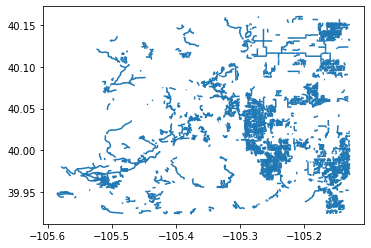

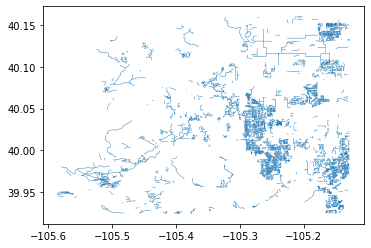

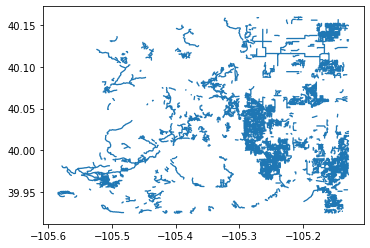

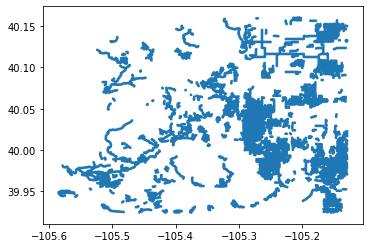

In [101]:
roads_cat1.plot()
buffered_cat1_30.plot()
buffered_cat1_60.plot()
buffered_cat1_90.plot()

<AxesSubplot:>

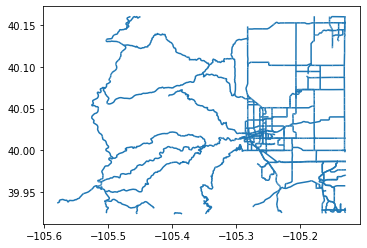

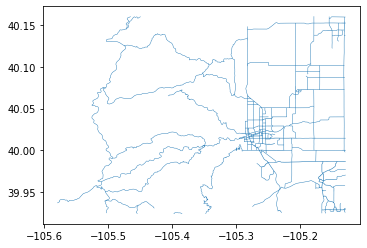

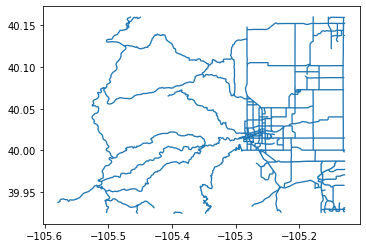

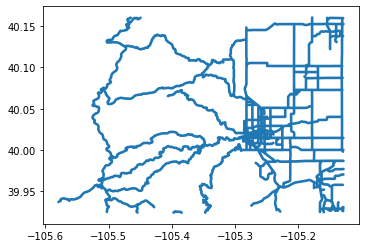

In [102]:
roads_cat2.plot()
buffered_cat2_30.plot()
buffered_cat2_60.plot()
buffered_cat2_90.plot()

<AxesSubplot:>

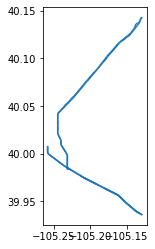

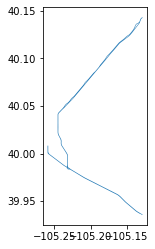

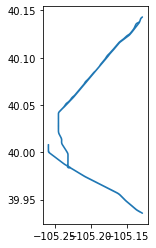

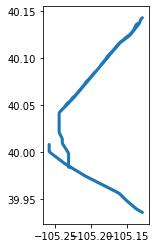

In [103]:
roads_cat3.plot()
buffered_cat3_30.plot()
buffered_cat3_60.plot()
buffered_cat3_90.plot()

<AxesSubplot:>

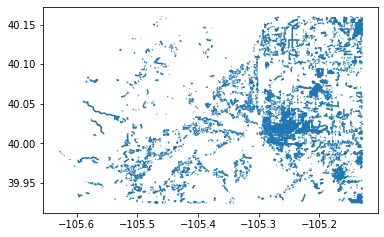

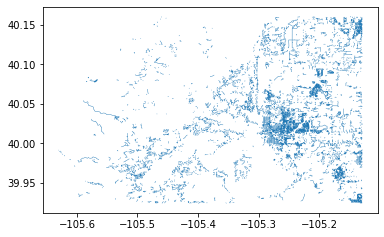

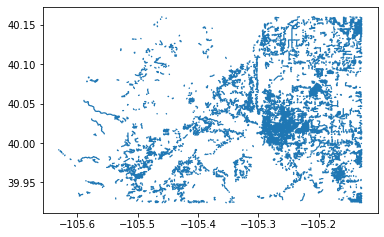

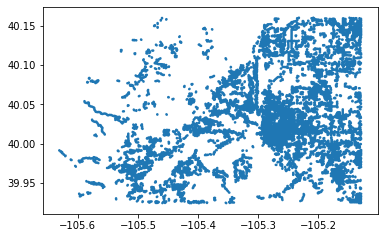

In [104]:
roads_cat4.plot()
buffered_cat4_30.plot()
buffered_cat4_60.plot()
buffered_cat4_90.plot()

In [105]:
def join_buildings(buffer_category, roads_category):
    buffered_category = {
        'cat1_30': buffered_cat1_30,
        'cat1_60': buffered_cat1_60,
        'cat1_90': buffered_cat1_90,
        'cat2_30': buffered_cat2_30,
        'cat2_60': buffered_cat2_60,
        'cat2_90': buffered_cat2_90,
        'cat3_30': buffered_cat3_30,
        'cat3_60': buffered_cat3_60,
        'cat3_90': buffered_cat3_90,
        'cat4_30': buffered_cat4_30,
        'cat4_60': buffered_cat4_60,
        'cat4_90': buffered_cat4_90,

    }.get(buffer_category)

    joined = buildings_gdf.sjoin(buffered_category, how='left')
    #joined = buildings_gdf.sjoin(buffered_category, how="left", predicate='intersects')
    joined.rename(columns={'index_right': 'index_roads'}, inplace=True)
    #joined.drop_duplicates(subset='id_left',inplace=True)
    if roads_category:
        joined['buffered_highway'] = \
            joined['buffered_highway'].apply(lambda x: 'not_residential' if pd.isnull(x) else x)
    else:
        joined['buffered_highway'] = \
            joined['buffered_highway'].apply(lambda x: 'residential' if pd.isnull(x) else x)

    joined.reset_index(inplace=True, drop=True)
    
    return joined

In [106]:
buffer_categories = ['cat1_30', 'cat1_60', 'cat1_90','cat2_30','cat2_60','cat2_90',\
                    'cat3_30', 'cat3_60', 'cat3_90','cat4_30','cat4_60','cat4_90']
roads_category = 1                      # 1 is residential, 0 is ['primary', 'secondary','tertiary']
joined_buildings1 = join_buildings(buffer_categories[0],roads_category)
joined_buildings2 = join_buildings(buffer_categories[1],roads_category)
joined_buildings3 = join_buildings(buffer_categories[2],roads_category)
roads_category = 0
joined_buildings4 = join_buildings(buffer_categories[3],roads_category)
joined_buildings5 = join_buildings(buffer_categories[4],roads_category)
joined_buildings6 = join_buildings(buffer_categories[5],roads_category)
joined_buildings7 = join_buildings(buffer_categories[6],roads_category)
joined_buildings8 = join_buildings(buffer_categories[7],roads_category)
joined_buildings9 = join_buildings(buffer_categories[8],roads_category)
joined_buildings10 = join_buildings(buffer_categories[9],roads_category)
joined_buildings11 = join_buildings(buffer_categories[10],roads_category)
joined_buildings12 = join_buildings(buffer_categories[11],roads_category)

In [107]:
print(joined_buildings1.shape)
print(joined_buildings2.shape)
print(joined_buildings3.shape)
print(joined_buildings4.shape)
print(joined_buildings5.shape)
print(joined_buildings6.shape)
print(joined_buildings7.shape)
print(joined_buildings8.shape)
print(joined_buildings9.shape)
print(joined_buildings10.shape)
print(joined_buildings11.shape)
print(joined_buildings12.shape)

(23069, 14)
(23069, 14)
(23069, 14)
(23069, 14)
(23069, 14)
(23069, 14)
(23069, 14)
(23069, 14)
(23069, 14)
(23069, 14)
(23069, 14)
(23069, 14)


In [108]:
joined_buildings1.groupby('official_type').count()

,id_left,building,geometry,all_tag_keys,all_tags,index_landuse,landuse,land_building,index_official,OBJECTID,index_roads,id_right,buffered_highway
official_type,,,,,,,,,,,,,
NON_RES,2382,2382,2382,2382,2382,754,2382,2382,2382,2382,661,661,2382
RES,20687,20687,20687,20687,20687,6335,20687,20687,20687,20687,18400,18400,20687


In [109]:
joined_buildings1.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       not_residential      1721      1721      1721          1721   
              residential           661       661       661           661   
RES           not_residential      2287      2287      2287          2287   
              residential         18400     18400     18400         18400   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       not_residential       1721            617     1721   
              residential            661            137      661   
RES           not_residential       2287            508     2287   
              residential          18400           5827    18400   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       not_residential            1721            1721      1721   
              residential                 661             661       661   
RES           not_residential            2287            2287      2287   
              residential               18400           18400     18400   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       not_residential             0         0  
              residential               661       661  
RES           not_residential             0         0  
              residential             18400     18400

In [110]:
joined_buildings1[(joined_buildings1['land_building'] == 'commercial')\
               &(joined_buildings1['buffered_highway'] == 'residential')].shape

(55, 14)

In [111]:
joined_buildings2.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       not_residential      1016      1016      1016          1016   
              residential          1366      1366      1366          1366   
RES           not_residential       244       244       244           244   
              residential         20443     20443     20443         20443   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       not_residential       1016            434     1016   
              residential           1366            320     1366   
RES           not_residential        244             37      244   
              residential          20443           6298    20443   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       not_residential            1016            1016      1016   
              residential                1366            1366      1366   
RES           not_residential             244             244       244   
              residential               20443           20443     20443   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       not_residential             0         0  
              residential              1366      1366  
RES           not_residential             0         0  
              residential             20443     20443

In [112]:
joined_buildings3.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       not_residential       636       636       636           636   
              residential          1746      1746      1746          1746   
RES           not_residential        82        82        82            82   
              residential         20605     20605     20605         20605   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       not_residential        636            296      636   
              residential           1746            458     1746   
RES           not_residential         82              8       82   
              residential          20605           6327    20605   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       not_residential             636             636       636   
              residential                1746            1746      1746   
RES           not_residential              82              82        82   
              residential               20605           20605     20605   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       not_residential             0         0  
              residential              1746      1746  
RES           not_residential             0         0  
              residential             20605     20605

In [113]:
joined_buildings4.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       non_res_road          853       853       853           853   
              residential          1529      1529      1529          1529   
RES           non_res_road         2525      2525      2525          2525   
              residential         18162     18162     18162         18162   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       non_res_road           853            229      853   
              residential           1529            525     1529   
RES           non_res_road          2525            758     2525   
              residential          18162           5577    18162   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       non_res_road                853             853       853   
              residential                1529            1529      1529   
RES           non_res_road               2525            2525      2525   
              residential               18162           18162     18162   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       non_res_road              853       853  
              residential                 0         0  
RES           non_res_road             2525      2525  
              residential                 0         0

In [114]:
joined_buildings5.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       non_res_road         1562      1562      1562          1562   
              residential           820       820       820           820   
RES           non_res_road         6550      6550      6550          6550   
              residential         14137     14137     14137         14137   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       non_res_road          1562            486     1562   
              residential            820            268      820   
RES           non_res_road          6550           2031     6550   
              residential          14137           4304    14137   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       non_res_road               1562            1562      1562   
              residential                 820             820       820   
RES           non_res_road               6550            6550      6550   
              residential               14137           14137     14137   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       non_res_road             1562      1562  
              residential                 0         0  
RES           non_res_road             6550      6550  
              residential                 0         0

In [115]:
joined_buildings6.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       non_res_road         1965      1965      1965          1965   
              residential           417       417       417           417   
RES           non_res_road        11495     11495     11495         11495   
              residential          9192      9192      9192          9192   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       non_res_road          1965            630     1965   
              residential            417            124      417   
RES           non_res_road         11495           3810    11495   
              residential           9192           2525     9192   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       non_res_road               1965            1965      1965   
              residential                 417             417       417   
RES           non_res_road              11495           11495     11495   
              residential                9192            9192      9192   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       non_res_road             1965      1965  
              residential                 0         0  
RES           non_res_road            11495     11495  
              residential                 0         0

In [116]:
joined_buildings7.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       residential          2380      2380      2380          2380   
              roads_cat3              2         2         2             2   
RES           residential         20685     20685     20685         20685   
              roads_cat3              2         2         2             2   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       residential           2380            752     2380   
              roads_cat3               2              2        2   
RES           residential          20685           6335    20685   
              roads_cat3               2              0        2   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       residential                2380            2380      2380   
              roads_cat3                    2               2         2   
RES           residential               20685           20685     20685   
              roads_cat3                    2               2         2   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       residential                 0         0  
              roads_cat3                  2         2  
RES           residential                 0         0  
              roads_cat3                  2         2

In [117]:
joined_buildings8.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       residential          2291      2291      2291          2291   
              roads_cat3             91        91        91            91   
RES           residential         20237     20237     20237         20237   
              roads_cat3            450       450       450           450   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       residential           2291            698     2291   
              roads_cat3              91             56       91   
RES           residential          20237           6129    20237   
              roads_cat3             450            206      450   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       residential                2291            2291      2291   
              roads_cat3                   91              91        91   
RES           residential               20237           20237     20237   
              roads_cat3                  450             450       450   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       residential                 0         0  
              roads_cat3                 91        91  
RES           residential                 0         0  
              roads_cat3                450       450

In [118]:
joined_buildings9.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       residential          2191      2191      2191          2191   
              roads_cat3            191       191       191           191   
RES           residential         19632     19632     19632         19632   
              roads_cat3           1055      1055      1055          1055   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       residential           2191            642     2191   
              roads_cat3             191            112      191   
RES           residential          19632           5823    19632   
              roads_cat3            1055            512     1055   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       residential                2191            2191      2191   
              roads_cat3                  191             191       191   
RES           residential               19632           19632     19632   
              roads_cat3                 1055            1055      1055   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       residential                 0         0  
              roads_cat3                191       191  
RES           residential                 0         0  
              roads_cat3               1055      1055

In [119]:
len(areahandler.osm_data)

46142

In [120]:
keys_list = []
for sublist in areahandler.osm_data:
    keys_list.append(sublist[3])

In [121]:
keys_list_flat = [val for sublist in keys_list for val in sublist]

In [122]:
unique_keys = sorted(list(set(keys_list_flat)))

In [123]:
unique_keys

['access',
 'access:conditional',
 'addr:buildingname',
 'addr:city',
 'addr:country',
 'addr:county',
 'addr:flats',
 'addr:housename',
 'addr:housenumber',
 'addr:housenumber_1',
 'addr:postcode',
 'addr:state',
 'addr:street',
 'addr:unit',
 'after_school',
 'air_conditioning',
 'alt_name',
 'amenity',
 'amenity_1',
 'animal_shelter',
 'architect',
 'architect:wikipedia',
 'area',
 'atm',
 'automated',
 'bbq',
 'bench',
 'bicycle_parking',
 'bin',
 'branch',
 'brand',
 'brand:wikidata',
 'brand:wikipedia',
 'bridge',
 'building',
 'building:colour',
 'building:flats',
 'building:levels',
 'building:levels:underground',
 'building:material',
 'building:min_level',
 'building:part',
 'building:use',
 'building_1',
 'bus',
 'capacity',
 'capacity:disabled',
 'changing_table',
 'club',
 'construction',
 'contact:website',
 'content',
 'covered',
 'craft',
 'cuisine',
 'currency:USD',
 'currency:others',
 'damage:reconstruction',
 'delivery',
 'demolished:building',
 'denomination',
 'de

In [124]:
key_freq = []
for key in unique_keys:
    key_freq.append(keys_list_flat.count(key))
    

In [125]:
len(key_freq)

233

In [126]:
keys_tuples = list(zip(unique_keys, key_freq))
keys_freq_df = pd.DataFrame(keys_tuples, columns = ['Key', 'Freq'])

In [127]:
keys_freq_df.sort_values(by=['Freq'], inplace=True, ascending=False)

In [128]:
keys_freq_df.reset_index(inplace=True, drop=True)

In [129]:
keys_freq_df.head()

,Key,Freq
0,building,46142
1,addr:street,9756
2,addr:housenumber,8935
3,addr:city,8137
4,addr:state,7213


In [130]:
keys_freq_df.sort_values(by=['Key'], inplace=False, ascending=True).head(20)

,Key,Freq
33,access,58
159,access:conditional,1
173,addr:buildingname,1
3,addr:city,8137
9,addr:country,979
139,addr:county,2
54,addr:flats,18
62,addr:housename,12
2,addr:housenumber,8935
171,addr:housenumber_1,1


In [131]:
keys_freq_df.head(21)

,Key,Freq
0,building,46142
1,addr:street,9756
2,addr:housenumber,8935
3,addr:city,8137
4,addr:state,7213
5,addr:postcode,6730
6,source,2465
7,name,1276
8,building:levels,995
9,addr:country,979


In [132]:
selected_tags = ['source','addr:street','name','building:levels',\
                'roof:shape','amenity','brand','website','shop']
num_keys = len(selected_tags)+2

In [133]:
len(selected_tags)

9

In [134]:
def preprocess_data(input_data, value_tags, selected_tags):
    col_pos = 2
    for tag_key in selected_tags:
        col_name = tag_key
        input_data.insert(col_pos,col_name,0)
        input_data[col_name] = input_data.apply(lambda x: 1 if tag_key in list(x['all_tag_keys']) \
            else 0, axis=1)

    for tag_key in value_tags:
        input_data[tag_key] = input_data.apply(lambda x: x['all_tags'].get(tag_key) \
            if tag_key in list(x['all_tag_keys']) else 0, axis=1)

    # fix anomalies in FFX County data
    input_data.drop(input_data[(input_data['building:levels'] == 'K-6')].index, inplace=True)
    input_data.loc[(input_data['building:levels'] == '-1,1,2,3'),'building:levels']=4

    input_data.drop(columns=['all_tag_keys', 'all_tags'], inplace=True)

    input_data['official_type'] = \
    input_data['official_type'].apply(lambda x: 1 if x == 'RES' else 0)

    return input_data

In [135]:
def add_buffers(input_data,col_names, buffers_list):
    for num in range(0, len(col_names)):
        input_data.insert(num+2,col_names[num],buffers_list[num])
        input_data[col_names[num]] = input_data[col_names[num]].apply(lambda x: 1 if x == 'residential' else 0)

    return input_data

In [136]:
#num_buffers = 6
#buffer_loc = 0
#value_tags = ['roof:shape','building:levels']
#col_names = ['buffer_cat1_30','buffer_cat1_60','buffer_cat1_90',\
#            'buffer_cat2_30','buffer_cat2_60','buffer_cat2_90']
#buffers_list = [joined_buildings1['buffered_highway'],joined_buildings2['buffered_highway'],\
#                joined_buildings3['buffered_highway'],joined_buildings4['buffered_highway'],\
#                joined_buildings5['buffered_highway'],joined_buildings6['buffered_highway']]

num_buffers = 12
buffer_loc = 0
value_tags = ['roof:shape','building:levels']
col_names = ['buffer_cat1_30','buffer_cat1_60','buffer_cat1_90',\
            'buffer_cat2_30','buffer_cat2_60','buffer_cat2_90',\
            'buffer_cat3_30','buffer_cat3_60','buffer_cat3_90',\
            'buffer_cat4_30','buffer_cat4_60','buffer_cat4_90']
buffers_list = [joined_buildings1['buffered_highway'],joined_buildings2['buffered_highway'],\
                joined_buildings3['buffered_highway'],joined_buildings4['buffered_highway'],\
                joined_buildings5['buffered_highway'],joined_buildings6['buffered_highway'],\
                joined_buildings7['buffered_highway'],joined_buildings8['buffered_highway'],\
                joined_buildings9['buffered_highway'],joined_buildings10['buffered_highway'],\
                joined_buildings11['buffered_highway'],joined_buildings12['buffered_highway']]
backup_data = joined_buildings1.copy()
#input_data = input_data[['geometry','official_type','land_building','all_tag_keys','all_tags']]
#input_data = input_data[['geometry','official_type','building','landuse','all_tag_keys','all_tags']]
#input_data = input_data[['geometry','official_type','building','landuse',\
#                        'all_tag_keys','all_tags','id_left']]
#input_data = input_data[['geometry','official_type','building','landuse','amenity_key','parking_area',\
#                        'all_tag_keys','all_tags']]
backup_data = backup_data[['geometry','official_type','building','landuse','land_building',\
                        'all_tag_keys','all_tags','id_left']]
backup_data.insert(len(backup_data.columns), 'area',backup_data['geometry'].to_crs(epsg=32610).area)
backup_data = preprocess_data(backup_data,value_tags,selected_tags)

backup_data = add_buffers(backup_data,col_names[buffer_loc:buffer_loc+num_buffers],\
                         buffers_list[buffer_loc:buffer_loc+num_buffers])

In [137]:
len(areahandler.amenity_data)

1956

In [138]:
# transform the list of roads into a pandas DataFrame
amenity_colnames = ['amenity_key', 'geometry']
amenity_df = pd.DataFrame(areahandler.amenity_data, columns=amenity_colnames)

In [139]:
amenity_df.head()

,amenity_key,geometry
0,cinema,"POLYGON ((-105.1360267 39.9299163, -105.135822..."
1,parking,"POLYGON ((-105.1369877 39.9334874, -105.136880..."
2,parking,"POLYGON ((-105.1369792 39.9342742, -105.136610..."
3,parking,"POLYGON ((-105.13442 39.9350571, -105.1343052 ..."
4,parking,"POLYGON ((-105.1330943 39.93495, -105.1330941 ..."


In [140]:
amenity_df.shape

(1956, 2)

In [141]:
amenity_categories = amenity_df.groupby(['amenity_key'])['geometry'].count().reset_index(name="count")

In [142]:
amenity_categories.tail(50)

,amenity_key,count
5,bicycle_rental,1
6,boat_storage,2
7,bus_station,2
8,cafe,4
9,car_rental,2
10,car_sharing,1
11,car_wash,8
12,cinema,4
13,clinic,3
14,community_centre,6


In [143]:
parking_df = amenity_df[(amenity_df['amenity_key'] == 'parking') | (amenity_df['amenity_key'] == 'parking_space')]

In [144]:
parking_df = parking_df.assign(amenity_key='parking')

In [145]:
parking_df.reset_index(inplace=True, drop=True)

In [146]:
parking_df.shape

(1369, 2)

In [147]:
parking_gdf = geopandas.GeoDataFrame(parking_df.copy(),crs="EPSG:4326",geometry='geometry')

In [148]:
parking_gdf.insert(len(parking_gdf.columns), 'parking_area',parking_gdf['geometry'].to_crs(epsg=32610).area)

In [149]:
parking_gdf.head()

,amenity_key,geometry,parking_area
0,parking,"POLYGON ((-105.13699 39.93349, -105.13688 39.9...",6298.029530
1,parking,"POLYGON ((-105.13698 39.93427, -105.13661 39.9...",33494.246614
2,parking,"POLYGON ((-105.13442 39.93506, -105.13431 39.9...",12029.327064
3,parking,"POLYGON ((-105.13309 39.93495, -105.13309 39.9...",28713.589906
4,parking,"POLYGON ((-105.13171 39.93346, -105.13170 39.9...",20234.275854


In [150]:
parking_gdf.shape

(1369, 3)

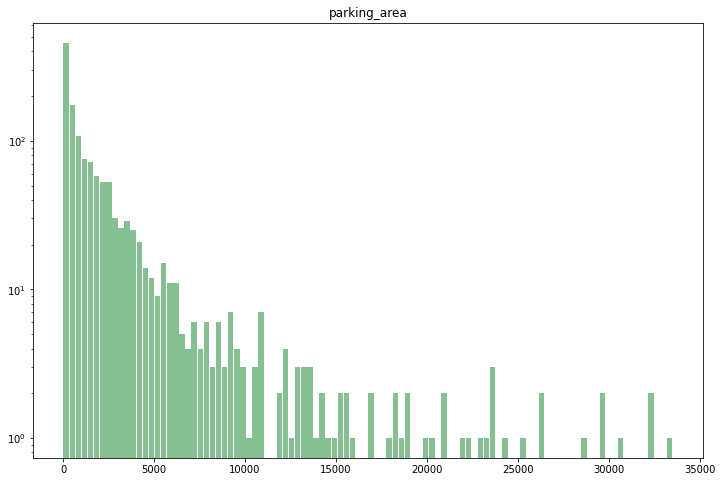

In [151]:
hist = parking_gdf.hist(bins=100, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.yscale('log')

In [152]:
## changes:
# nb_class -> n_classes

breaks = jenkspy.jenks_breaks(parking_gdf['parking_area'], n_classes = 3) 
print(breaks)

[8.186031843492922, 4406.370000970154, 14972.94972593379, 33494.24661399375]


In [153]:
bins_list = ['bin1','bin2','bin3']
parking_gdf['cut_jenks'] = pd.cut(parking_gdf['parking_area'],
                                bins=breaks,
                                labels=bins_list,
                                include_lowest=True)

In [154]:
parking_gdf.head()

,amenity_key,geometry,parking_area,cut_jenks
0,parking,"POLYGON ((-105.13699 39.93349, -105.13688 39.9...",6298.029530,bin2
1,parking,"POLYGON ((-105.13698 39.93427, -105.13661 39.9...",33494.246614,bin3
2,parking,"POLYGON ((-105.13442 39.93506, -105.13431 39.9...",12029.327064,bin2
3,parking,"POLYGON ((-105.13309 39.93495, -105.13309 39.9...",28713.589906,bin3
4,parking,"POLYGON ((-105.13171 39.93346, -105.13170 39.9...",20234.275854,bin3


In [155]:
for bin in bins_list:
    parking_gdf.insert(len(parking_gdf.columns),bin,0)
    parking_gdf[bin] = parking_gdf.apply(lambda x: 1 if x['cut_jenks'] == bin\
                                     else 0, axis=1)

In [156]:
parking_gdf.head()

,amenity_key,geometry,parking_area,cut_jenks,bin1,bin2,bin3
0,parking,"POLYGON ((-105.13699 39.93349, -105.13688 39.9...",6298.029530,bin2,0,1,0
1,parking,"POLYGON ((-105.13698 39.93427, -105.13661 39.9...",33494.246614,bin3,0,0,1
2,parking,"POLYGON ((-105.13442 39.93506, -105.13431 39.9...",12029.327064,bin2,0,1,0
3,parking,"POLYGON ((-105.13309 39.93495, -105.13309 39.9...",28713.589906,bin3,0,0,1
4,parking,"POLYGON ((-105.13171 39.93346, -105.13170 39.9...",20234.275854,bin3,0,0,1


In [157]:
backup_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'roof:shape', 'building:levels', 'name', 'addr:street',
       'source', 'building', 'landuse', 'land_building', 'id_left', 'area'],
      dtype='object')

In [158]:
radius_list = [30,60,90]
counter = 1
for bin in bins_list:
    for radius in radius_list:
        parking_buffer = parking_gdf.copy()
        parking_buffer = parking_buffer[['geometry',bin]]
        col_name = 'parking_cat'+str(counter)
        counter += 1
        parking_buffer.rename(columns={bin: col_name}, inplace=True)
        parking_buffer['geometry'] = parking_buffer['geometry'].to_crs(epsg=32610).buffer(radius)
        parking_buffer.to_crs(epsg=4326, inplace=True)
        buildings_parking = backup_data.sjoin(parking_buffer, how="left", predicate='intersects')
        buildings_parking[col_name] = buildings_parking[col_name].fillna(0)
        buildings_parking.drop_duplicates(subset='id_left',inplace=True)
        buildings_parking.reset_index(inplace=True, drop=True)
        backup_data.insert(len(backup_data.columns),col_name,list(buildings_parking[col_name]))

In [159]:
backup_data.drop(columns=['id_left'], inplace=True)

In [160]:
backup_data.shape

(23069, 36)

In [161]:
backup_data.head()

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
0,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...",1,1,1,1,1,1,1,1,1,...,2717.828862,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((-105.26486 40.00597, -105.26486 40.0...",1,0,0,1,1,1,0,1,1,...,897.072468,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((-105.26486 40.00602, -105.26469 40.0...",1,0,1,1,1,1,1,1,1,...,908.453864,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((-105.26461 40.00653, -105.26441 40.0...",1,0,0,1,1,1,0,1,1,...,888.170766,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((-105.26530 40.00707, -105.26515 40.0...",1,0,1,1,1,1,0,1,1,...,886.992555,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
backup_data.loc[(backup_data['building:levels'] == '1;3;2'),'building:levels']=3
backup_data.loc[(backup_data['building:levels'] == '4 floors'),'building:levels']=4

In [163]:
# save backup file to "/DATA2/dse313/group15/Boulder/Boulder_Backup_Data/"

#content_boulder = os.listdir("/DATA2/dse313/group15/Boulder/")
if "Boulder_Backup_Data" not in os.listdir("/DATA2/dse313/group15/Boulder/"):
   os.mkdir("/DATA2/dse313/group15/Boulder/Boulder_Backup_Data")

backup_data.to_pickle("/DATA2/dse313/group15/Boulder/Boulder_Backup_Data/Boulder.pkl") 

In [4]:
backup_data = pd.read_pickle("/DATA2/dse313/group15/Boulder/Boulder_Backup_Data/Boulder.pkl")

In [5]:
input_data = backup_data.copy()

In [6]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'roof:shape', 'building:levels', 'name', 'addr:street',
       'source', 'building', 'landuse', 'land_building', 'area',
       'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',
       'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',
       'parking_cat9'],
      dtype='object')

In [7]:
input_data.drop(columns=['land_building', 'roof:shape'], inplace=True)

In [8]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [9]:
input_data.groupby('landuse').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
landuse,,,,,,,,,,,,,,,,,,,,,
no_landuse,15980,15980,15980,15980,15980,15980,15980,15980,15980,15980,...,15980,15980,15980,15980,15980,15980,15980,15980,15980,15980
residential,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435,...,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435
non_res,624,624,624,624,624,624,624,624,624,624,...,624,624,624,624,624,624,624,624,624,624
construction,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
recreation_ground,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
storage,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
cemetery,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
farmyard,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
forest,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [10]:
input_data['landuse'].unique()

array(['non_res', 'no_landuse', 'residential', 'construction', 'storage',
       'forest', 'recreation_ground', 'cemetery', 'farmyard'],
      dtype=object)

In [11]:
input_data.shape

(23069, 34)

In [12]:
input_data.groupby('building').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(20)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
building,,,,,,,,,,,,,,,,,,,,,
house,12302,12302,12302,12302,12302,12302,12302,12302,12302,12302,...,12302,12302,12302,12302,12302,12302,12302,12302,12302,12302
yes,6775,6775,6775,6775,6775,6775,6775,6775,6775,6775,...,6775,6775,6775,6775,6775,6775,6775,6775,6775,6775
apartments,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163,...,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163
residential,642,642,642,642,642,642,642,642,642,642,...,642,642,642,642,642,642,642,642,642,642
static_caravan,515,515,515,515,515,515,515,515,515,515,...,515,515,515,515,515,515,515,515,515,515
retail,333,333,333,333,333,333,333,333,333,333,...,333,333,333,333,333,333,333,333,333,333
office,264,264,264,264,264,264,264,264,264,264,...,264,264,264,264,264,264,264,264,264,264
commercial,210,210,210,210,210,210,210,210,210,210,...,210,210,210,210,210,210,210,210,210,210
garage,162,162,162,162,162,162,162,162,162,162,...,162,162,162,162,162,162,162,162,162,162


In [13]:
content_boulder = os.listdir("/DATA2/dse313/group15/Boulder/")
if "Boulder_Input_Data" not in content_boulder:
   os.mkdir("/DATA2/dse313/group15/Boulder/Boulder_Input_Data")
input_data.to_pickle("/DATA2/dse313/group15/Boulder/Boulder_Input_Data/Boulder.pkl") 

In [14]:

#input_data = pd.read_pickle("/DATA2/dse313/group15/Boulder/Boulder_Input_Data/Boulder.pkl")

In [15]:
#type(input_data['building'].unique())

In [16]:
#test_array = np.array(['a','b','c','dormitory', 'office', 'yes', 'university'], dtype=object)

In [17]:
#test_array

In [18]:
#a = np.array([1, 2, 3, 2, 4, 1,9])
#b = np.array([3, 4, 5, 6,7,8])
#np.setxor1d(a, b)

In [19]:
input_data['building'].unique()

array(['dormitory', 'office', 'yes', 'university', 'church', 'retail',
       'government', 'sports_centre', 'garage', 'stadium', 'school',
       'public', 'industrial', 'apartments', 'amenity', 'commercial',
       'house', 'roof', 'residential', 'garages', 'shed', 'hotel',
       'detached', 'warehouse', 'museum', 'parking', 'construction',
       'greenhouse', 'terrace', 'hospital', 'civic', 'semidetached_house',
       'service', 'static_caravan', 'kindergarten', 'kiosk', 'carport'],
      dtype=object)

In [20]:
common_features = np.array(['apartments', 'church', 'civic', 'commercial', 'construction',
       'detached', 'dormitory', 'garage', 'garages', 'greenhouse',
       'hospital', 'hotel', 'house', 'industrial', 'kindergarten',
       'office', 'parking', 'public', 'residential', 'retail', 'roof',
       'school', 'semidetached_house', 'service', 'shed',
       'static_caravan', 'terrace', 'warehouse', 'yes'], dtype=object)

In [21]:
unique_buildings = np.setxor1d(input_data['building'].unique(), common_features).tolist()

In [22]:
unique_buildings

['amenity',
 'carport',
 'government',
 'kiosk',
 'museum',
 'sports_centre',
 'stadium',
 'university']

In [23]:
len(unique_buildings)

8

In [24]:
input_data[input_data['building'].isin(unique_buildings)].shape

(93, 34)

In [25]:
input_data['building'] = input_data['building'].apply(\
                                lambda x: 'misc_buildings' if x in(unique_buildings)
                                                else x)

In [26]:
input_data[input_data['building'].isin(unique_buildings)].shape

(0, 34)

In [27]:
input_data.shape

(23069, 34)

In [28]:
input_data.groupby('building').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
building,,,,,,,,,,,,,,,,,,,,,
house,12302,12302,12302,12302,12302,12302,12302,12302,12302,12302,...,12302,12302,12302,12302,12302,12302,12302,12302,12302,12302
yes,6775,6775,6775,6775,6775,6775,6775,6775,6775,6775,...,6775,6775,6775,6775,6775,6775,6775,6775,6775,6775
apartments,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163,...,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163
residential,642,642,642,642,642,642,642,642,642,642,...,642,642,642,642,642,642,642,642,642,642
static_caravan,515,515,515,515,515,515,515,515,515,515,...,515,515,515,515,515,515,515,515,515,515
retail,333,333,333,333,333,333,333,333,333,333,...,333,333,333,333,333,333,333,333,333,333
office,264,264,264,264,264,264,264,264,264,264,...,264,264,264,264,264,264,264,264,264,264
commercial,210,210,210,210,210,210,210,210,210,210,...,210,210,210,210,210,210,210,210,210,210
garage,162,162,162,162,162,162,162,162,162,162,...,162,162,162,162,162,162,162,162,162,162


In [29]:
common_landuse = np.array(['non_res', 'no_landuse', 'residential', 'construction',
       'forest', 'recreation_ground', 'cemetery', 'farmyard'], dtype=object)

In [30]:
unique_landuse = np.setxor1d(input_data['landuse'].unique(), common_landuse).tolist()

In [31]:
unique_landuse

['storage']

In [32]:
input_data[input_data['landuse'].isin(unique_landuse)].shape

(5, 34)

In [33]:
input_data['landuse'] = input_data['landuse'].apply(\
                                lambda x: 'misc_landuse' if x in(unique_landuse)
                                                else x)

In [34]:
input_data[input_data['landuse'].isin(unique_landuse)].shape

(0, 34)

In [35]:
input_data.groupby('landuse').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
landuse,,,,,,,,,,,,,,,,,,,,,
no_landuse,15980,15980,15980,15980,15980,15980,15980,15980,15980,15980,...,15980,15980,15980,15980,15980,15980,15980,15980,15980,15980
residential,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435,...,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435
non_res,624,624,624,624,624,624,624,624,624,624,...,624,624,624,624,624,624,624,624,624,624
construction,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
recreation_ground,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
misc_landuse,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
cemetery,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
farmyard,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
forest,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [36]:
input_data['landuse'].replace(['residential','non_res','forest','cemetery','recreation_ground',\
                                'construction','farmyard'],['residential_landuse','non_res_landuse',\
                                'forest_landuse','cemetery_landuse','recreation_ground_landuse',\
                                'construction_landuse','farmyard_landuse'], inplace=True)

In [37]:
input_data.groupby('landuse').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
landuse,,,,,,,,,,,,,,,,,,,,,
no_landuse,15980,15980,15980,15980,15980,15980,15980,15980,15980,15980,...,15980,15980,15980,15980,15980,15980,15980,15980,15980,15980
residential_landuse,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435,...,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435
non_res_landuse,624,624,624,624,624,624,624,624,624,624,...,624,624,624,624,624,624,624,624,624,624
construction_landuse,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
recreation_ground_landuse,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
misc_landuse,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
cemetery_landuse,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
farmyard_landuse,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
forest_landuse,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [38]:
input_data.shape

(23069, 34)

In [39]:
Boulder_baseline = input_data.copy()

In [40]:
Boulder_baseline.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [41]:
Boulder_baseline = Boulder_baseline[['geometry', 'official_type', 'building']]

In [42]:
Boulder_baseline.columns

Index(['geometry', 'official_type', 'building'], dtype='object')

In [43]:
Boulder_baseline.head()

,geometry,official_type,building
0,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...",1,dormitory
1,"POLYGON ((-105.26486 40.00597, -105.26486 40.0...",1,dormitory
2,"POLYGON ((-105.26486 40.00602, -105.26469 40.0...",1,dormitory
3,"POLYGON ((-105.26461 40.00653, -105.26441 40.0...",1,dormitory
4,"POLYGON ((-105.26530 40.00707, -105.26515 40.0...",1,dormitory


In [44]:
residential_list = ['residential','apartments','dormitory', 'house','semidetached_house']
Boulder_baseline['building'] = Boulder_baseline['building'].apply(\
                                lambda x: 'residential' if x in(residential_list)
                                                else x)

In [45]:
non_residential_list = ['public','commercial','industrial', 'school','church','office',
                        'retail','hotel','warehouse','kindergarten','civic','hospital']
Boulder_baseline['building'] = Boulder_baseline['building'].apply(\
                                lambda x: 'non_residential' if x in(non_residential_list)
                                                else x)

In [46]:
unknown_list = ['yes','detached','terrace', 'garage','roof','shed',
                'parking','garages','greenhouse','static_caravan','service','construction',
                'misc_buildings']
Boulder_baseline['building'] = Boulder_baseline['building'].apply(\
                                lambda x: 'unknown' if x in(unknown_list)
                                                else x)

In [47]:
Boulder_baseline.head()

,geometry,official_type,building
0,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...",1,residential
1,"POLYGON ((-105.26486 40.00597, -105.26486 40.0...",1,residential
2,"POLYGON ((-105.26486 40.00602, -105.26469 40.0...",1,residential
3,"POLYGON ((-105.26461 40.00653, -105.26441 40.0...",1,residential
4,"POLYGON ((-105.26530 40.00707, -105.26515 40.0...",1,residential


In [48]:
Boulder_baseline.groupby('building').count()

,geometry,official_type
building,,
non_residential,1118,1118
residential,14140,14140
unknown,7811,7811


In [49]:
Boulder_baseline.groupby(['official_type','building']).count()

geometry
official_type building                 
0             non_residential      1006
              residential           123
              unknown              1253
1             non_residential       112
              residential         14017
              unknown              6558

In [50]:
# content_boulder = os.listdir("/DATA2/dse313/group15/Boulder/")

if "Boulder_baseline" not in os.listdir("/DATA2/dse313/group15/Boulder/"):
   os.mkdir("/DATA2/dse313/group15/Boulder/Boulder_baseline")
Boulder_baseline.to_file("/DATA2/dse313/group15/Boulder/Boulder_baseline/Boulder_baseline.shp")

<ipython-input-50-12f29b2f7ca2>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  Boulder_baseline.to_file("/DATA2/dse313/group15/Boulder/Boulder_baseline/Boulder_baseline.shp")


In [51]:
Boulder_baseline.groupby('official_type').count()

,geometry,building
official_type,,
0,2382,2382
1,20687,20687


In [52]:
def nominal_transform(input_data, value_tags):
    ohe = preprocessing.OneHotEncoder(sparse = False)
    for tag in value_tags:
        ohe_results = ohe.fit_transform(input_data[[tag]])
        input_data.reset_index(inplace=True, drop=True)
        input_data = pd.concat([input_data, \
            pd.DataFrame(ohe_results, columns=ohe.categories_[0].tolist())], axis=1)
        input_data.drop(columns=[tag], inplace=True)
        
    return input_data

In [53]:
# nominal transform

#value_tags = ['roof:shape','building','landuse']
#value_tags = ['roof:shape','land_building']
#value_tags = ['roof:shape','building']
value_tags = ['building','landuse']
nominal_data = input_data.copy()
#nominal_data['roof:shape'] = nominal_data['roof:shape'].astype(str)
nominal_data = nominal_transform(nominal_data, value_tags)
nominal_features = list(nominal_data.columns[2:])
nominal_features

/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['buffer_cat1_30',
 'buffer_cat1_60',
 'buffer_cat1_90',
 'buffer_cat2_30',
 'buffer_cat2_60',
 'buffer_cat2_90',
 'buffer_cat3_30',
 'buffer_cat3_60',
 'buffer_cat3_90',
 'buffer_cat4_30',
 'buffer_cat4_60',
 'buffer_cat4_90',
 'shop',
 'website',
 'brand',
 'amenity',
 'building:levels',
 'name',
 'addr:street',
 'source',
 'area',
 'parking_cat1',
 'parking_cat2',
 'parking_cat3',
 'parking_cat4',
 'parking_cat5',
 'parking_cat6',
 'parking_cat7',
 'parking_cat8',
 'parking_cat9',
 'apartments',
 'church',
 'civic',
 'commercial',
 'construction',
 'detached',
 'dormitory',
 'garage',
 'garages',
 'greenhouse',
 'hospital',
 'hotel',
 'house',
 'industrial',
 'kindergarten',
 'misc_buildings',
 'office',
 'parking',
 'public',
 'residential',
 'retail',
 'roof',
 'school',
 'semidetached_house',
 'service',
 'shed',
 'static_caravan',
 'terrace',
 'warehouse',
 'yes',
 'cemetery_landuse',
 'construction_landuse',
 'farmyard_landuse',
 'forest_landuse',
 'misc_landuse',
 'no_landuse'

In [54]:
nominal_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source', 'area',
       'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',
       'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',
       'parking_cat9', 'apartments', 'church', 'civic', 'commercial',
       'construction', 'detached', 'dormitory', 'garage', 'garages',
       'greenhouse', 'hospital', 'hotel', 'house', 'industrial',
       'kindergarten', 'misc_buildings', 'office', 'parking', 'public',
       'residential', 'retail', 'roof', 'school', 'semidetached_house',
       'service', 'shed', 'static_caravan', 'terrace', 'warehouse', 'yes',
       'cemetery_landuse', 'construction_landuse', 'farm

In [55]:
sorted(nominal_data.columns)

['addr:street',
 'amenity',
 'apartments',
 'area',
 'brand',
 'buffer_cat1_30',
 'buffer_cat1_60',
 'buffer_cat1_90',
 'buffer_cat2_30',
 'buffer_cat2_60',
 'buffer_cat2_90',
 'buffer_cat3_30',
 'buffer_cat3_60',
 'buffer_cat3_90',
 'buffer_cat4_30',
 'buffer_cat4_60',
 'buffer_cat4_90',
 'building:levels',
 'cemetery_landuse',
 'church',
 'civic',
 'commercial',
 'construction',
 'construction_landuse',
 'detached',
 'dormitory',
 'farmyard_landuse',
 'forest_landuse',
 'garage',
 'garages',
 'geometry',
 'greenhouse',
 'hospital',
 'hotel',
 'house',
 'industrial',
 'kindergarten',
 'misc_buildings',
 'misc_landuse',
 'name',
 'no_landuse',
 'non_res_landuse',
 'office',
 'official_type',
 'parking',
 'parking_cat1',
 'parking_cat2',
 'parking_cat3',
 'parking_cat4',
 'parking_cat5',
 'parking_cat6',
 'parking_cat7',
 'parking_cat8',
 'parking_cat9',
 'public',
 'recreation_ground_landuse',
 'residential',
 'residential_landuse',
 'retail',
 'roof',
 'school',
 'semidetached_house',

Confusion matrix:
[[ 388   77]
 [  99 4050]]


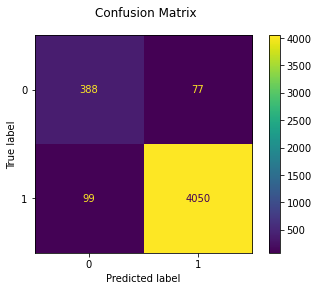

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       465
           1       0.98      0.98      0.98      4149

    accuracy                           0.96      4614
   macro avg       0.89      0.91      0.90      4614
weighted avg       0.96      0.96      0.96      4614




In [56]:
# latest, building and landuse

X = nominal_data[nominal_features]
y = nominal_data["official_type"]
weights = {0:2.0, 1:1.0}

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(X_test)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Confusion matrix:
[[ 1919   463]
 [  651 20036]]


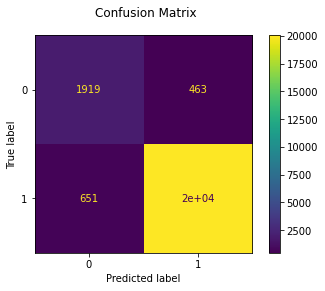

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      2382
           1       0.98      0.97      0.97     20687

    accuracy                           0.95     23069
   macro avg       0.86      0.89      0.87     23069
weighted avg       0.95      0.95      0.95     23069




In [57]:
# result for generating output shape file

X = nominal_data[nominal_features]
y = nominal_data["official_type"]
#weights = 'balanced'
weights = {0:2.0, 1:1.0}
dt = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)
y_pred = cross_val_predict(dt, X, y, cv=10)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt}:\n"
    f"{metrics.classification_report(y, y_pred)}\n"
)

In [58]:
output_data = nominal_data.copy()
output_data.drop(columns=['official_type','buffer_cat2_30', 'buffer_cat2_60','buffer_cat2_90'], inplace=True)
output_data.insert(1,'official',y)
output_data.insert(2,'predicted',y_pred)
output_filtered = output_data.copy()
#output_filtered = output_filtered[output_filtered['official'] != output_filtered['predicted']]
output_filtered['official'] = \
    output_filtered['official'].apply(lambda x: 'RES' if x == 1 else 'NON_RES')
output_filtered['predicted'] = \
    output_filtered['predicted'].apply(lambda x: 'RES' if x == 1 else 'NON_RES')

In [59]:
#output_filtered.to_file("./Datasets/OSM/Geopandas_Output/filtered_output.shp")

# content_boulder = os.listdir("/DATA2/dse313/group15/Boulder/")
if "Boulder_Predictions" not in os.listdir("/DATA2/dse313/group15/Boulder/"):
   os.mkdir("/DATA2/dse313/group15/Boulder/Boulder_Predictions")
output_data.to_file("/DATA2/dse313/group15/Boulder/Boulder_Predictions/Boulder_Predictions.shp")

<ipython-input-59-f041e5f66a56>:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  output_data.to_file("/DATA2/dse313/group15/Boulder/Boulder_Predictions/Boulder_Predictions.shp")


Confusion matrix:
[[  7655   2526]
 [ 14634 179856]]


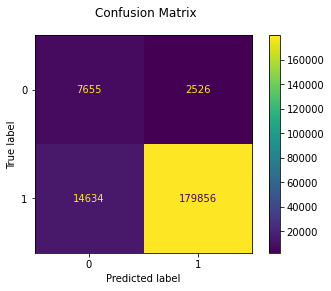

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.34      0.75      0.47     10181
           1       0.99      0.92      0.95    194490

    accuracy                           0.92    204671
   macro avg       0.66      0.84      0.71    204671
weighted avg       0.95      0.92      0.93    204671




In [62]:
# Test on FFX 100%

X = nominal_data[nominal_features]
y = nominal_data["official_type"]

FFX_nominal = pd.read_pickle("/DATA2/dse313/group15/FFX/FFX_Processed_Data/FFX_nominal_data.pkl")

FFX_X = FFX_nominal[nominal_features]
FFX_y = FFX_nominal["official_type"]

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)

#weights = 'balanced'
weights = {0:2.0, 1:1.0}
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(FFX_X)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(FFX_y, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(FFX_y, predicted)}\n"
)

In [ ]:
# Test on Mecklenburg 100% data

# Mecklenburg_nominal = pd.read_pickle("./Mecklenburg_Processed_Data/Mecklenburg_nominal_data.pkl")

# X = nominal_data[nominal_features]
# y = nominal_data["official_type"]

# Mecklenburg_X = Mecklenburg_nominal[nominal_features]
# Mecklenburg_y = Mecklenburg_nominal["official_type"]

# #weights = 'balanced'
# weights = {0:2.0, 1:1.0}
# dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
#                                 random_state=0,min_impurity_decrease = 0.0001)

# X_train, X_test, y_train, y_test = train_test_split(\
#     X, y, test_size=0.2, shuffle=True)

# # Learn on FFX
# dt_split.fit(X_train, y_train)

# # Predict the target on Mecklenburg
# predicted = dt_split.predict(Mecklenburg_X)

# # 1 = RES; 0 = NON_RES

# disp = metrics.ConfusionMatrixDisplay.from_predictions(Mecklenburg_y, predicted)
# disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

# plt.show()

# print(
#     f"Classification report for classifier {dt_split}:\n"
#     f"{metrics.classification_report(Mecklenburg_y, predicted)}\n"
# )

In [61]:
#X.to_pickle("./Boulder_Processed_Data/Boulder_X.pkl")  
#y.to_pickle("./Boulder_Processed_Data/Boulder_y.pkl")

if 'Boulder_Processed_Data' not in os.listdir("/DATA2/dse313/group15/Boulder/"):
    os.mkdir("/DATA2/dse313/group15/Boulder/Boulder_Processed_Data")
nominal_data.to_pickle("/DATA2/dse313/group15/Boulder/Boulder_Processed_Data/Boulder_nominal_data.pkl")

In [ ]:
# Ablation Study

In [63]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [64]:
ablation_data = input_data.copy()

In [65]:
ablation_data.drop(columns=['buffer_cat1_30', 'buffer_cat1_60',\
                        'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',\
                        'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',\
                        'buffer_cat4_60', 'buffer_cat4_90',\
                        \
                        \
                        'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',\
                        'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',\
                        'parking_cat9'], inplace=True)

In [66]:
ablation_data.columns

Index(['geometry', 'official_type', 'shop', 'website', 'brand', 'amenity',
       'building:levels', 'name', 'addr:street', 'source', 'building',
       'landuse', 'area'],
      dtype='object')

In [67]:
# nominal transform

value_tags = ['building','landuse']
#nominal_data = input_data.copy()
#value_tags = ['building']
ablation_data = nominal_transform(ablation_data, value_tags)
ablation_features = list(ablation_data.columns[2:])
ablation_features

/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['shop',
 'website',
 'brand',
 'amenity',
 'building:levels',
 'name',
 'addr:street',
 'source',
 'area',
 'apartments',
 'church',
 'civic',
 'commercial',
 'construction',
 'detached',
 'dormitory',
 'garage',
 'garages',
 'greenhouse',
 'hospital',
 'hotel',
 'house',
 'industrial',
 'kindergarten',
 'misc_buildings',
 'office',
 'parking',
 'public',
 'residential',
 'retail',
 'roof',
 'school',
 'semidetached_house',
 'service',
 'shed',
 'static_caravan',
 'terrace',
 'warehouse',
 'yes',
 'cemetery_landuse',
 'construction_landuse',
 'farmyard_landuse',
 'forest_landuse',
 'misc_landuse',
 'no_landuse',
 'non_res_landuse',
 'recreation_ground_landuse',
 'residential_landuse']

In [68]:
ablation_data.columns

Index(['geometry', 'official_type', 'shop', 'website', 'brand', 'amenity',
       'building:levels', 'name', 'addr:street', 'source', 'area',
       'apartments', 'church', 'civic', 'commercial', 'construction',
       'detached', 'dormitory', 'garage', 'garages', 'greenhouse', 'hospital',
       'hotel', 'house', 'industrial', 'kindergarten', 'misc_buildings',
       'office', 'parking', 'public', 'residential', 'retail', 'roof',
       'school', 'semidetached_house', 'service', 'shed', 'static_caravan',
       'terrace', 'warehouse', 'yes', 'cemetery_landuse',
       'construction_landuse', 'farmyard_landuse', 'forest_landuse',
       'misc_landuse', 'no_landuse', 'non_res_landuse',
       'recreation_ground_landuse', 'residential_landuse'],
      dtype='object')

In [69]:
ablation_data.shape

(23069, 50)

Confusion matrix:
[[ 378  100]
 [  92 4044]]


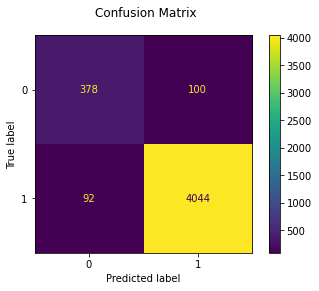

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       478
           1       0.98      0.98      0.98      4136

    accuracy                           0.96      4614
   macro avg       0.89      0.88      0.89      4614
weighted avg       0.96      0.96      0.96      4614




In [70]:
X = ablation_data[ablation_features]
y = ablation_data["official_type"]
weights = {0:2.0, 1:1.0}

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(X_test)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)